## Интеллектуальный анализ данных – весна 2025
## Домашнее задание 4: kNN. Линейные модели. Работа с признаками

Правила:

* Домашнее задание оценивается в 10 баллов.

* Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.

* Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.

* Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

* Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.  

* Если в задании есть вопрос на рассуждение, то за отсутствие ответа на него балл за задание будет снижен вполовину.

### Задание 1:  Визуализация решающих поверхностей в kNN.

В этом задании мы изобразим решающую поверхность для классификатора kNN, чтобы наглядно увидеть, как классификатор принимает решения для новых объектов. Для простоты будем работать с усеченным датасетом `Palmer Penguins`, содержащим информацию о характеристиках трех видов пингвинов: `Adelie`, `Chinstrap` и `Gentoo`:



*   Species — вид пингвина (целевая переменная).
*   Island — остров, на котором была сделана запись.
*   Clutch Completion — завершенность кладки яиц.
*   Date Egg — закодированная дата откладки яиц (число дней от самой ранней даты в данных).
*   Culmen Length (mm) — длина клюва.
*   Culmen Depth (mm) — глубина клюва.
*   Flipper Length (mm) — длина ласт.
*   Body Mass (g) — масса тела в граммах.
*   Sex — пол особи.
*   Delta 15 N (o/oo) и Delta 13 C (o/oo) — изотопные значения, характеризующие пищевые предпочтения.

Описание полного набора данных и дополнительную информацию о проекте можно найти [здесь](https://allisonhorst.github.io/palmerpenguins/index.html) и [здесь](https://www.kaggle.com/datasets/parulpandey/palmer-archipelago-antarctica-penguin-data?resource=download).

![Palmer Penguins](https://allisonhorst.github.io/palmerpenguins/reference/figures/lter_penguins.png)



In [489]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [490]:
import warnings

warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8")

In [491]:
data = pd.read_csv('penguins_data.csv')
data.head(10)

,Species,Island,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo)
0,Chinstrap,Dream,Yes,382,50.9,19.1,196.0,3550.0,MALE,10.02372,-24.86594
1,Chinstrap,Dream,Yes,741,45.2,17.8,198.0,3950.0,FEMALE,8.88942,-24.49433
2,Gentoo,Biscoe,Yes,744,46.5,13.5,210.0,4550.0,FEMALE,7.99530,-25.32829
3,Chinstrap,Dream,Yes,10,45.2,16.6,191.0,3250.0,FEMALE,9.62357,-24.78984
4,Gentoo,Biscoe,Yes,13,48.4,14.4,203.0,4625.0,FEMALE,8.16582,-26.13971
5,Gentoo,Biscoe,Yes,22,48.1,15.1,209.0,5500.0,MALE,8.45738,-26.22664
6,Gentoo,Biscoe,Yes,13,51.1,16.5,225.0,5250.0,MALE,8.20660,-26.36863
7,Gentoo,Biscoe,No,392,42.7,13.7,208.0,3950.0,FEMALE,8.14567,-26.59467
8,Adelie,Biscoe,Yes,14,39.6,20.7,191.0,3900.0,FEMALE,8.80967,-26.78958
9,Gentoo,Biscoe,Yes,735,46.1,13.2,211.0,4500.0,FEMALE,7.99300,-25.51390


In [492]:
data.shape

(344, 11)

**Задача 1.1 (0.5 балла)** Есть ли в наборе данных пропущенные значения? Если да, то удалите их. Есть ли в наборе данных категориальные признаки? Если да, то закодируйте их самым оптимальным способом. Аргументируйте свой выбор.

In [493]:
data.isna().sum()

Species                 0
Island                  0
Clutch Completion       0
Date Egg                0
Culmen Length (mm)      2
Culmen Depth (mm)       2
Flipper Length (mm)     2
Body Mass (g)           2
Sex                    10
Delta 15 N (o/oo)      14
Delta 13 C (o/oo)      13
dtype: int64

### Из численных данных:

У пары пингвинов нет данныых о размерах чстях тел. Возможно, они были крайне буйными пингвинами. Эти данные можно заменить средними значениями по полам (для этого далее проверим, что средние размеры частей тел у разных полов пингвинов различаются)

Также у большего числа пингвинов не удалось собрать данные о вкусовых предпочтениях.
Возможно, влияет пол и фактор выынашивания яиц (`Clutch Completion`)

### Из категориальных данных:

Иногда в данных пропущен пола. Возможно, пингвины стеснялись и не хотели показываться исследователям.

Для этого проверим зависимость таких величин как масса (самцы могут быть больше), фактор завершенности кладки яиц, и вкусовые предпочтения.

Сначала разберемся с категиальными данными, то есть
 расследуем гендер пингвинов.

Пороверим зависимость гендера от веса.

In [494]:
data["Sex"].value_counts()

Sex
MALE      168
FEMALE    165
.           1
Name: count, dtype: int64

помимо пропусков, есть пингвин с точкой как гендером, его тоже недообследовали.

<Axes: ylabel='Body Mass (g)'>

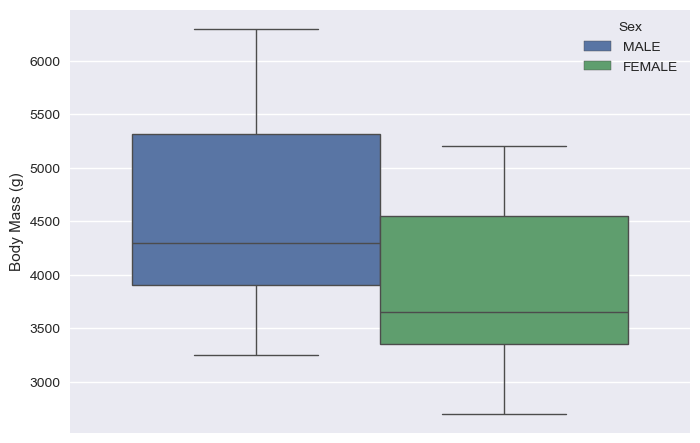

In [495]:
data_no_sex = (data["Sex"].isna()) | (data["Sex"] == ".")
data_with_sex = data[~data_no_sex]

sns.boxplot(
    data=data_with_sex,
    hue="Sex",
    y="Body Mass (g)",
)

Самцы, вроде, в среднем тяжелее.

Далее проверим, значит ли то, что яйцо высиживают, что это делает самка.

In [496]:
data_with_sex.groupby("Sex")["Clutch Completion"].value_counts()

Sex     Clutch Completion
FEMALE  Yes                  147
        No                    18
MALE    Yes                  151
        No                    17
Name: count, dtype: int64

Данные по полам различаются на уровне погрешности.

Однако проверим, во всех ли видах так

In [497]:
data_with_sex_grouped = data_with_sex.groupby(["Species", "Sex"])

data_with_sex_grouped["Clutch Completion"].value_counts()

Species    Sex     Clutch Completion
Adelie     FEMALE  Yes                  66
                   No                    7
           MALE    Yes                  66
                   No                    7
Chinstrap  FEMALE  Yes                  27
                   No                    7
           MALE    Yes                  27
                   No                    7
Gentoo     FEMALE  Yes                  54
                   No                    4
           MALE    Yes                  58
                   No                    3
Name: count, dtype: int64

Отвергаем гипотезу, что фактор высиживания влияет на пол:
оба пола в равной пропорции высиживают яйца.

Проверим гипотезу о влиянии пола на размер чатей тела.
Для этого выыведем графики размеров частей тем у женских и мужских особей.

<Axes: title={'center': 'Длинна ласт'}, ylabel='Flipper Length (mm)'>

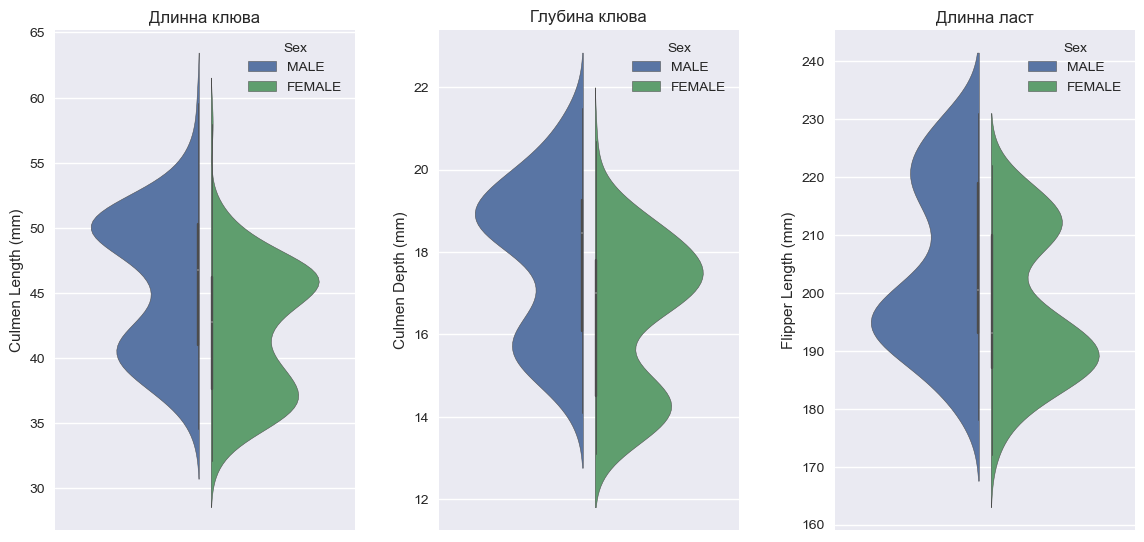

In [498]:
fig = plt.figure(figsize=(12, 5))

# можно делать на subplots, но тк графика всего два, можно обойтись и .add_axes
ax_1 = fig.add_axes(
    [0, 1, 0.25, 1],
    title="Длинна клюва",
)

ax_2 = fig.add_axes(
    [0.32, 1, 0.25, 1],
    title="Глубина клюва",
)

ax_3 = fig.add_axes(
    [0.65, 1, 0.25, 1],
    title="Длинна ласт",
)

sns.violinplot(
    data=data_with_sex,
    y="Culmen Length (mm)",
    hue="Sex",
    ax=ax_1,
    gap=.1,
    split=True
)

sns.violinplot(
    data=data_with_sex,
    y="Culmen Depth (mm)",
    hue="Sex",
    ax=ax_2,
    gap=.1,
    split=True
)

sns.violinplot(
    data=data_with_sex,
    y="Flipper Length (mm)",
    hue="Sex",
    ax=ax_3,
    gap=.1,
    split=True
)


Видно, что в среднем у самцов показатели больше, но разница малая
и нет выявленной границы, разделяющую пол пингвинов с какой либо валидной вероятностью.

Мы показали, что пол пингвинов можно примерно определить только по весу. 

Проверим, сколько пингвинов мы сможем правильно разделить, если поставим четкое разграничение в 3750

In [499]:
is_male = data_with_sex["Body Mass (g)"] < 3750

wrong_n = is_male.compare(data_with_sex["Sex"] == "FEMALE").shape[0]
1 - (wrong_n / is_male.shape[0])

0.7207207207207207

Таким образом, получили условие, которое пусть и не идеальное
(чуть более 70% угадываются верно), но это уже лучше, чем случайность.

Теперь вспомним, что у никоторых пингвинов отсутсвует и масса.
Посмотрим на данныее с отсутствующей массой 

In [500]:
data_no_mass = data[data["Body Mass (g)"].isna()]
data_no_mass

,Species,Island,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo)
44,Adelie,Torgersen,Yes,746,NaN,NaN,NaN,NaN,NaN,NaN,NaN
130,Gentoo,Biscoe,No,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


В этих данных больше половины данных потеряны, так что можем считать
потерю этих семплов несущесвенной. Удалим эти семплы.

In [501]:
data.drop(data_no_mass.index, inplace=True)

Проверим пропуски данных

In [502]:
data.isna().sum()

Species                 0
Island                  0
Clutch Completion       0
Date Egg                0
Culmen Length (mm)      0
Culmen Depth (mm)       0
Flipper Length (mm)     0
Body Mass (g)           0
Sex                     8
Delta 15 N (o/oo)      12
Delta 13 C (o/oo)      11
dtype: int64

Теперь восстановим в данных гендеры пингвинов, опираясь на их (пингвинов)
вес

In [503]:
data["Sex"].value_counts()

Sex
MALE      168
FEMALE    165
.           1
Name: count, dtype: int64

In [504]:
data.loc[data_no_sex & (data["Body Mass (g)"] < 3750), "Sex"] = "FEMALE"
data.loc[data_no_sex & (data["Body Mass (g)"] > 3750), "Sex"] = "MALE"

Проверим, что пропуски убраны и больше нет фальшивых значений!

In [505]:
data["Sex"].value_counts()

Sex
MALE      173
FEMALE    169
Name: count, dtype: int64

In [506]:
data.isna().sum()

Species                 0
Island                  0
Clutch Completion       0
Date Egg                0
Culmen Length (mm)      0
Culmen Depth (mm)       0
Flipper Length (mm)     0
Body Mass (g)           0
Sex                     0
Delta 15 N (o/oo)      12
Delta 13 C (o/oo)      11
dtype: int64

Теперь заполним данные числовые.
Для этого разобьем пингвинов по видам и полам, и дадим кажому пропущенному медианное значение одной из шести групп.

In [507]:
data_with_delta = ~(data["Delta 15 N (o/oo)"].isna()) | (data["Delta 13 C (o/oo)"].isna())

pivot_delta = pd.pivot_table(
    data[data_with_delta],
    values=["Delta 15 N (o/oo)", "Delta 13 C (o/oo)"],
    columns="Sex",
    index="Species",
    aggfunc="mean",
)

pivot_delta

Delta 13 C (o/oo)            Delta 15 N (o/oo)          
Sex                  FEMALE       MALE            FEMALE      MALE
Species                                                           
Adelie           -25.786088 -25.823086          8.791041  8.931411
Chinstrap        -24.565405 -24.550104          9.250962  9.464535
Gentoo           -26.197205 -26.174507          8.193405  8.292403

Значения разнятся незначительно, и можно просто
проставить среднее значения в пропуски. 

In [508]:
delta_13_mean = data["Delta 13 C (o/oo)"].mean()
delta_15_mean = data["Delta 15 N (o/oo)"].mean()

data.loc[data["Delta 13 C (o/oo)"].isna(), "Delta 13 C (o/oo)"] = delta_13_mean
data.loc[data["Delta 15 N (o/oo)"].isna(), "Delta 15 N (o/oo)"] = delta_15_mean

Последний раз проверим пропуски.

In [509]:
data.isna().sum()

Species                0
Island                 0
Clutch Completion      0
Date Egg               0
Culmen Length (mm)     0
Culmen Depth (mm)      0
Flipper Length (mm)    0
Body Mass (g)          0
Sex                    0
Delta 15 N (o/oo)      0
Delta 13 C (o/oo)      0
dtype: int64

Победа! Пропускрв нет!

Целевую категориальную переменную закодируйте в ординальном порядке: 
Chinstrap = 0,Gentoo = 1, Adelie = 2. Можно воспользоваться [OrdinalEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html).

Теперь сохраним информацию о признаках в переменную
`X`, а о целевой переменной – в переменную `y`.

In [510]:
from sklearn.preprocessing import OrdinalEncoder

species_categories = ["Chinstrap", "Gentoo", "Adelie"]

ecd = OrdinalEncoder(categories=[species_categories], dtype=np.int32)

data["Species Categories"] = ecd.fit_transform(data[["Species"]])
data.head()

,Species,Island,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Species Categories
0,Chinstrap,Dream,Yes,382,50.9,19.1,196.0,3550.0,MALE,10.02372,-24.86594,0
1,Chinstrap,Dream,Yes,741,45.2,17.8,198.0,3950.0,FEMALE,8.88942,-24.49433,0
2,Gentoo,Biscoe,Yes,744,46.5,13.5,210.0,4550.0,FEMALE,7.99530,-25.32829,1
3,Chinstrap,Dream,Yes,10,45.2,16.6,191.0,3250.0,FEMALE,9.62357,-24.78984,0
4,Gentoo,Biscoe,Yes,13,48.4,14.4,203.0,4625.0,FEMALE,8.16582,-26.13971,1


In [511]:
y = data["Species Categories"]
X = data.drop(["Species Categories", "Species"], axis=1)

CATEGORY_TO_SPECIES = {
    0: "Chinstrap",
    1: "Gentoo",
    2: "Adelie",
}

In [512]:
y.head()

0    0
1    0
2    1
3    0
4    1
Name: Species Categories, dtype: int32

In [513]:
X.head()

,Island,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo)
0,Dream,Yes,382,50.9,19.1,196.0,3550.0,MALE,10.02372,-24.86594
1,Dream,Yes,741,45.2,17.8,198.0,3950.0,FEMALE,8.88942,-24.49433
2,Biscoe,Yes,744,46.5,13.5,210.0,4550.0,FEMALE,7.99530,-25.32829
3,Dream,Yes,10,45.2,16.6,191.0,3250.0,FEMALE,9.62357,-24.78984
4,Biscoe,Yes,13,48.4,14.4,203.0,4625.0,FEMALE,8.16582,-26.13971


Предобработка закончена!

**Задача 1.2 (0.5 балла)** Используя функцию `train_test_split()`, разделите выборку на тренировочную и тестовую, и долю тестовой выборки задайте равной 0.3. Так как разбиение осуществляется случайным образом, не забудьте зафиксировать `np.random.seed()` для воспроизводимости результатов.

Используйте аргумент `stratify` при разбиении. Почему это важно?

In [514]:
SEED_CODE = 42
np.random.seed(SEED_CODE)

In [515]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y,
)

Что такое этот ваш `stratify`?

Ну, предстаим ситуацию, когда пытаемся вылечить больных. Пусть на выборке 90_000 здоровых и 10_000 заболевших. И вот мы, такие умницы, берем 80% на обучающую выборку. И о божечки-кошечки, все заболевшие уходят в `test` выборку и наш алгоритм показывает чудеса скоринга на `train`! Но есть ньюанс c `test`...

Чтобы так не было, хорошо бы сохранять пропорцию target class'ов в выборке на обучение и на тест.
Для этого и используем `stratify`, передавая ему наши таргет классы.

**Задача 1.3 (1 балл)** На тренировочной выборке обучите шесть классификаторов kNN, отличающихся только числом соседей. Для первого классификатора число соседей поставьте равным 1, для второго - 3, для третьего – 5, для четвертого – 10, для пятого – 15 и для шестого – 25 (обратите внимание на параметр `n_neighbours` класса `KNeighborsClassifier`). Для обучения используйте только два признака:  `Flipper Length (mm)` и `Body Mass (g)`  – и евклидово расстояние. Не забудьте масштабировать признаки, например, при помощи модуля `StandardScaler`.

Выведите долю правильных ответов на тренировочной и тестовой выборках для каждого классификатора.

In [516]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

n_neightbours = [1, 3, 5, 10, 15, 25]
classifiers = [KNeighborsClassifier(k) for k in n_neightbours]
col_to_train = ["Flipper Length (mm)", "Body Mass (g)"]

scaler = StandardScaler()
scaler.fit(X_train[col_to_train])

X_train_scalered = scaler.transform(X_train[col_to_train])
X_test_scalered = scaler.transform(X_test[col_to_train])

for clf in classifiers:
    clf.fit(X_train_scalered, y_train)

print("k  | train score% | test score%")
print("-------------------------------")
for i, clf in enumerate(classifiers):
    tr_score = np.round(clf.score(X_train_scalered, y_train), 4)
    te_score = np.round(clf.score(X_test_scalered, y_test), 4)
    k = str(n_neightbours[i]) if n_neightbours[i] > 9 else f"{n_neightbours[i]} "
    print(f"{k} | {np.round(tr_score * 100, 2)}        | {np.round(te_score * 100, 2)}")


k  | train score% | test score%
-------------------------------
1  | 97.07        | 72.82
3  | 87.03        | 76.7
5  | 83.68        | 77.67
10 | 83.68        | 78.64
15 | 82.85        | 77.67
25 | 83.26        | 77.67


У меня возникли вопросы к тому, зачем вообще нужен `Scaller` и 
насколько он помогает в обучении. 
Что нам, компьютер что ли жалко, что мы его желеем и делаем данные более чувствительными. Попробуем те же алгоритмы, но без  

In [557]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

n_neightbours = [1, 3, 5, 10, 15, 25]
classifiers_no_slaler = [KNeighborsClassifier(k).fit(X_train[col_to_train].values, y_train.values) for k in n_neightbours]
col_to_train = ["Flipper Length (mm)", "Body Mass (g)"]

print("k  | train score% | test score%")
print("-------------------------------")
for i, clf in enumerate(classifiers_no_slaler):
    tr_score = np.round(clf.score(X_train[col_to_train], y_train), 4)
    te_score = np.round(clf.score(X_test[col_to_train], y_test), 4)
    k = str(n_neightbours[i]) if n_neightbours[i] > 9 else f"{n_neightbours[i]} "
    print(f"{k} | {np.round(tr_score * 100, 2)}        | {np.round(te_score * 100, 2)}")

k  | train score% | test score%
-------------------------------
1  | 97.49        | 67.96
3  | 85.36        | 66.02
5  | 80.75        | 66.99
10 | 76.99        | 63.11
15 | 76.57        | 69.9
25 | 75.73        | 65.05


Максимум скора на `test` при использоании `Scaller` - 78%, без него - почти 70%.
Также оптимальное число k-соседей изменилось.

Также в среднем скор упал на примерно такое же значение.

Делаем вывод, что при более чувствительных данных (нормализованных) модель обучается лучше.

In [518]:
!pip install mlxtend

Если всё прошло успешно, то в выводе команды выше вы увидите сообщение вроде "successfully installed", а следующая ячейка выполнится без ошибок.

In [519]:
import mlxtend

**Задача 1.5 (1 балл)** Библиотека `mlxtend` позволяет достаточно просто визуализировать решающие поверхности обученных классификаторов. Изучите [документацию](http://rasbt.github.io/mlxtend/user_guide/plotting/plot_decision_regions/) библиотеки и найдите, как можно построить несколько графиков решающих поверхностей на сетке (decision regions grid). Постройте такую сетку графиков для обученных выше классификаторов.

**Подсказки:**
1. Вы можете использовать готовый код, приведённый в документации, и адаптировать его для нашего случая.
2. Вам могут понадобиться дополнительные библиотеки, которые используются в примере из документации.
3. Обратите внимание на то, как нужно изменить параметры `gridspec.GridSpec()` и `itertools.product()` для нашего числа классификаторов.
4. В функции `plot_decision_region()` используйте `y_train` и нужные столбцы из `X_train`. Возможно, их придётся перевести в формат массива `numpy`.
5. Если в задаче 1.3 вы сохраните обученные классификаторы в список, то не будет необходимости обучать их заново.
6. Построение графика может занять некоторое время – придётся немного подождать!

In [ ]:
from mlxtend.plotting import plot_decision_regions
import matplotlib.pyplot as plt
import itertools
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(12,9))
gs = gridspec.GridSpec(2, 3, wspace=0.2, hspace=0.2)

for clf, lab, grd in zip(classifiers,
                         n_neightbours,
                         itertools.product([0, 1], [0, 1, 2])):

    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(
        X=X_train_scalered,
        y=y_train.to_numpy(),
        clf=clf,
    )
    plt.title(f"KNN with {lab} as k")

plt.show()

**Задача 1.6 (0.5 балла)** Прокомментируйте результаты, полученные в задачах 1.3 и 1.5. Какое число соседей оптимально использовать для обучения классификатора? Поясните ваш выбор при помощи описания геометрии данных и получаемой решающей поверхности. Какие из результатов явно говорят о переобучении модели? Почему?

По скорингу лучше всего отработал KNN с 10 соседями. 
Логично взять ее как самую лучшую модель. Однако рисунок показывает, что при таких гиперпараметрах сущесвуют "островки" и проблелы внутри каждой зоны.

Сравнивая это с KNN: k=25 видим, что у последней модели значительно меньше разрырвов, а скоринг почти такой же.
Для работы модели лучше оставить ту модель, которая имеет более гладкие и четкие границы, несмотря на небольшую потерю скоринга на `test`

### Задание 2. KNN своими руками. 2,5 балла

**Задача 2.1 (2 балла)** В данном задании мы попробуем реализовать алгоритм KNN своими руками, делать мы будем KNN именно для классификации.

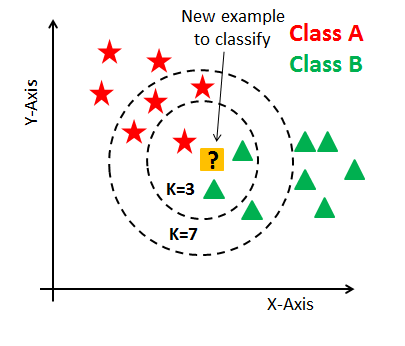

Рекомендации по реализации:
- Используйте `numpy` для представления данных в виде массивов, чтобы минимизировать преобразования.
- Избегайте циклов по всем объектам, по возможности используйте векторизированные операции.
- Обратите внимание на методы [np.linalg.norm()](https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html) и [np.argsort()](https://numpy.org/doc/stable/reference/generated/numpy.argsort.html), а также на класс `collections.Counter`.
- Особый плюс, если учтёте обработку возможных ошибок.

In [551]:
import numpy as np
from collections import Counter

class KNN:
    def __init__(self, k:int):
        self.k = k

    def fit(self, X: np.array, y: np.array):
        self.X = X
        self.y = y
        return self

    def predict(self, X):
        prediction = np.zeros(X.shape[0])
        
        for i, point in enumerate(X):
            distance = np.array([np.inf for i in range(self.k)], dtype=np.float64)
            index = np.array([-1 for i in range(self.k)])
            for i_n, neightbour in enumerate(self.X):
                dist = self.count_distance(point, neightbour)
                if np.any(dist < distance):
                    idx_first_less = np.where(distance > dist)[0][0]
                    distance = np.insert(distance, idx_first_less, dist)[:self.k]
                    index = np.insert(index, idx_first_less, i_n)[:self.k]
            tgts = self.y[index]
            t_v, t_c = np.unique(tgts, return_counts=True)
            idx = np.argmax(t_c)
            prediction[i] = t_v[idx]
        return prediction
                

    def count_distance(self, x, y):
        square = np.square(x - y)
        return np.sqrt(((x - y)**2).sum())

In [552]:
# Не меняйте файл!
def test_knn(KNN):
  knn = KNN(k=1)
  X_train =  np.array([[1, 1], [2, 2]])
  y_train =  np.array([0, 1])
  X_test =  np.array([[1.5, 1.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [0]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[9.5, 9.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[5.5, 5.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[15, 15]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[5, 5], [2, 2]])
  knn.fit(X_train, y_train)
  assert all(knn.predict(X_test) == [1, 0])

In [553]:
# Если тесты эти пройдены, то все верно!
test_knn(KNN)

**Задача 2.2 (0.5 балла)** Протестируйте ваш алгоритм на данных о пингвинах. Выведите лучший получившийся результат на тестовой выборке.

In [554]:
k_possible = [1, 2, 5, 15, 30, 50]
clasf = [KNN(k=nei) for nei in k_possible]

for cls in clasf:
    cls.fit(X_train_scalered, y_train.to_numpy())

print("k  | train score% | test score%")
print("-------------------------------")
for i, classi in enumerate(clasf):
    train_score = np.sum((classi.predict(X_train_scalered) == y_train.to_numpy())) / y_train.size

    test_score = np.sum((classi.predict(X_test_scalered) == y_test.to_numpy())) / y_test.size
    
    k = str(k_possible[i]) if n_neightbours[i] > 9 else f"{n_neightbours[i]} "
    print(f"{k} | {np.round(train_score * 100, 2)}        | {np.round(test_score * 100, 2)}")

k  | train score% | test score%
-------------------------------
1  | 97.07        | 71.84
3  | 86.61        | 67.96
5  | 83.26        | 77.67
15 | 82.43        | 77.67
30 | 83.26        | 79.61
50 | 79.5        | 79.61


### Задание 3: Линейная регрессия.

В этом задании мы рассмотрим различные аспекты построения линейной модели. Мы будем работать с одним из классических наборов данных в статистике, содержащим информацию о бриллиантах. Описание можно посмотреть [здесь](https://www.kaggle.com/shivam2503/diamonds).

In [525]:
data = pd.read_csv('diamonds.csv')
data.head(5)

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


Мы будем решать задачу предсказания цены бриллианта `price` в зависимости от его характеристик.

**Задача 3.1 (0.2 балла)** Есть ли в наборе данных пропущенные значения? Если да, удалите их.
Есть ли в наборе данных бессмысленные столбцы (признаки, не несущие дополнительной информации)? Если да, то удалите их.

In [526]:
data = data.drop("Unnamed: 0", axis=1)
data.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [527]:
data.isna().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

Минимальная предобработка сделана

**Задача 3.2 (0.2 балла)** Линейная регрессия основана на предположении о линейной связи между признаками и целевой переменной, а потому перед выбором переменных для включения в модель имеет смысл проверить, насколько эта связь выполняется. Для следующих пунктов нам также потребуются выборочные корреляции между признаками. Постройте матрицу корреляций между всеми вещественными признаками и целевой переменной (то есть в этой матрице будет $k+1$ строка, где $k$ – количество вещественных признаков).

Какие вещественные признаки имеют наибольшую корреляцию с целевой переменной?

In [452]:
numeric_columns = ["carat", "depth", "table", "price", "x", "y", "z"]
cor = data[numeric_columns].corr()
cor

,carat,depth,table,price,x,y,z
carat,1.000000,0.028224,0.181618,0.921591,0.975094,0.951722,0.953387
depth,0.028224,1.000000,-0.295779,-0.010647,-0.025289,-0.029341,0.094924
table,0.181618,-0.295779,1.000000,0.127134,0.195344,0.183760,0.150929
price,0.921591,-0.010647,0.127134,1.000000,0.884435,0.865421,0.861249
x,0.975094,-0.025289,0.195344,0.884435,1.000000,0.974701,0.970772
y,0.951722,-0.029341,0.183760,0.865421,0.974701,1.000000,0.952006
z,0.953387,0.094924,0.150929,0.861249,0.970772,0.952006,1.000000


In [453]:
cor["price"]

carat    0.921591
depth   -0.010647
table    0.127134
price    1.000000
x        0.884435
y        0.865421
z        0.861249
Name: price, dtype: float64

Получается очевидно, что признаки `carat`, `x`, `y`, `z` имеют 
наибольшее вниляние на цену.

Признак `carat` - качество драгоценного камня - очеивдно влияет на его цену.

Также вляюят и размеры камня: чем он больше, тем дороже.

**Задача 3.3 (0.2 балла)** Так как линейная модель складывает значения признаков с некоторыми весами, нам нужно аккуратно обработать категориальные признаки. Закодируйте категориальные признаки методом OneHot-кодирования (`pd.get_dummies()` или `OneHotEncoder` из `sklearn`).

Сначала оценим количесво категорий в каждом категриальном столбце.

Вдруг их 100500...

In [454]:
categorial = data.select_dtypes(include=['object']).columns.tolist()
for c in categorial:
    display(data[c].value_counts())

cut
Ideal        21551
Premium      13791
Very Good    12082
Good          4906
Fair          1610
Name: count, dtype: int64

color
G    11292
E     9797
F     9542
H     8304
D     6775
I     5422
J     2808
Name: count, dtype: int64

clarity
SI1     13065
VS2     12258
SI2      9194
VS1      8171
VVS2     5066
VVS1     3655
IF       1790
I1        741
Name: count, dtype: int64

Всего 20 штук в каждом категриальном признаке. Таким образом, мы 
добавим в датасет 20 новых колонок, а уберем 3. Не критично. Работаем.

In [455]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
encoded = encoder.fit_transform(data[categorial])
encoded_df = pd.DataFrame(encoded.toarray(), columns=encoder.get_feature_names_out(categorial))

data = pd.concat([data, encoded_df], axis=1)
data = data.drop(categorial, axis=1)

data.head()

,carat,depth,table,price,x,y,z,cut_Fair,cut_Good,cut_Ideal,...,color_I,color_J,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.23,61.5,55.0,326,3.95,3.98,2.43,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.21,59.8,61.0,326,3.89,3.84,2.31,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.23,56.9,65.0,327,4.05,4.07,2.31,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.29,62.4,58.0,334,4.20,4.23,2.63,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.31,63.3,58.0,335,4.34,4.35,2.75,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


**Задача 3.4 (0.2 балла)** Разделите выборку на тренировочную и тестовую. Долю тестовой выборки укажите равной 0.3. Не забудьте про параметр `stratify`.

In [456]:
from sklearn.model_selection import train_test_split

X_columns = data.columns.drop("price")

X_train, X_test, y_train, y_test = train_test_split(
    data[X_columns], data["price"], test_size=0.3, stratify=data["price"],
)

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

Прекрасная ошибка связна с тем, что цена, хоть и целевая переменная,
почти неограничена в возможных значениях, потому функция не понимает, какое отношение возможных цен нужно сохранить в тестовой и в обучающей выборке.

Следовательно, вопрос, какое (или какие) переменные мы хотим сохранить в равном отношении в выборках??

Пусть это останется цена, но для соблюдения баланса цен (чтобы в тестовую случайно не вошли только дорогие и только дешевые), впишем в данные столбец, который ранжирует цену от 1 до 10, где 10 - самая премиальная категория, а 1 - самая дешовая.

In [457]:
np.linspace(0, 1, 11)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [458]:
qtls = np.quantile(data["price"], np.linspace(0, 1, 11))
display(qtls)

conditions = [data["price"].between(qtls[i-1], qtls[i]) for i in range(1, 11)]
choices = [i for i in range(1, 11)]

data["price_quantil"] = np.select(conditions, choices)
data.head()

array([  326. ,   646. ,   837. ,  1087. ,  1698. ,  2401. ,  3465. ,
        4662. ,  6301.2,  9821. , 18823. ])

,carat,depth,table,price,x,y,z,cut_Fair,cut_Good,cut_Ideal,...,color_J,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2,price_quantil
0,0.23,61.5,55.0,326,3.95,3.98,2.43,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
1,0.21,59.8,61.0,326,3.89,3.84,2.31,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
2,0.23,56.9,65.0,327,4.05,4.07,2.31,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1
3,0.29,62.4,58.0,334,4.20,4.23,2.63,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
4,0.31,63.3,58.0,335,4.34,4.35,2.75,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1


In [459]:
X_columns = data.columns.drop(["price", "price_quantil"])

X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(
    data[X_columns], data["price"], test_size=0.3, stratify=data["price_quantil"],
)

**Задача 3.5 (0.3 балла)** Зачастую при использовании линейных моделей вещественные признаки масштабируются. При этом оценки коэффициентов теряют прямую статистическую интерпретацию ("при увеличении $X_1$ на 1, $y$ увеличивается на $w_1$"), но приобретают свойства, полезные в задачах машинного обучения. В этой задаче стандартизируйте вещественные признаки в тренировочной и тестовой выборках с помощью `StandardScaler`.

Объясните, как это повлияет на интерпретацию коэффициентов линейной регрессии.

In [460]:
from sklearn.preprocessing import StandardScaler

scaller = StandardScaler()
scaller.fit(X_train_d)

X_train_d = scaller.transform(X_train_d)
X_test_d = scaller.transform(X_test_d)

Теперь, получается, что все параметры одинакового масштаба. То есть коэффициенты лин модели,
полученнные при нормированных данных, можно считать за значимость параметра, чего нельзя сказать в случае ненормированных данных.

**Задача 3.6 (0.2 балла)** Оцените линейную регрессию на тренировочной выборке. Выведите среднеквадратичную ошибку на тренировочной и тестовой выборках.

In [461]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression().fit(X_train_d, y_train_d)

mse_train = np.mean( ( lr.predict(X_train_d) - y_train_d ) ** 2 )
mse_test = np.mean( ( lr.predict(X_test_d) - y_test_d ) ** 2 ) 

f"mse with train: {mse_train} and with test: {mse_test}"

'mse with train: 1270713.124348148 and with test: 1292293.7257793103'

**Задача 3.7 (0.3 балла)** Изучите [документацию](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) модуля `LinearRegression` и выведите полученные оценки коэффициентов. Назовите вещественные переменные, оценки коэффициентов которых по модулю на порядок превышают оценки прочих вещественных переменных.

In [462]:
coefficients = pd.DataFrame(
    index=data[X_columns].columns,
    data=lr.coef_,
    columns=["w"],
)
coefficients

,w
carat,5.306893e+03
depth,-7.867839e+01
table,-6.339349e+01
x,-1.042413e+03
y,5.438632e+00
z,-8.447571e+01
cut_Fair,-2.447990e+15
cut_Good,-4.180103e+15
cut_Ideal,-7.113869e+15
cut_Premium,-6.325651e+15


In [463]:
top_w_index = coefficients.abs().sort_values(by="w", ascending=False)[:10].index
coefficients.loc[top_w_index]

,w
color_G,-7.460771e+15
cut_Ideal,-7.113869e+15
color_E,-7.047585e+15
color_F,-6.967557e+15
color_H,-6.601388e+15
cut_Premium,-6.325651e+15
color_D,-6.065281e+15
cut_Very Good,-6.036540e+15
color_I,-5.493303e+15
cut_Good,-4.180103e+15


**Задача 3.8 (0.5 балла)** Как можно заметить из анализа корреляционной матрицы в задаче 3.3, между некоторыми признаками имеется сильная корреляция, что может быть индикатором проблемы *мультиколлинеарности*. Различия в порядке коэффициентов, выявленные в предыдущей задаче также намекают на её присутствие. Как известно, для решения этой проблемы можно либо исключить некоторые признаки из модели, либо использовать регуляризацию. Мы воспользуемся вторым вариантом.

Вспомним, что смысл регуляризации заключается в том, чтобы изменить функцию потерь так, чтобы устранить проблемы, появляющиеся из-за мультиколлинеарности. При L1-регуляризации предлагается минимизировать следующую функцию потерь:

$$
\|y - X\hat{w}\|^2 + \alpha\sum_{i=1}^k|w_i|
$$

Такая модель называется Lasso-регрессией.

При L2-регуляризации предлагается минимизировать следующую функцию потерь:

$$
\|y - X\hat{w}\|^2 + \alpha\|w\|^2
$$

Такая модель называется Ridge-регрессией.

Обучите Lasso-регрессию и Ridge-регрессию, установив гиперпараметр регуляризации равным 10. Для этого используйте модули `Lasso` и `Ridge` из `sklearn`. Сильно ли уменьшились веса? Сделайте вывод о том, насколько сильно проблема мультиколлинеарности проявлялась в изначальной регрессии.

In [464]:
from sklearn.linear_model import Lasso, Ridge

lasso = Lasso(10.0).fit(X_train_d, y_train_d)
ridge = Ridge(10.0).fit(X_train_d, y_train_d)

In [465]:
lasso.coef_

array([4860.19699657,  -46.80929597,  -48.70557227, -583.41820454,
         -0.        , -114.37975649, -119.76287234,  -42.42960722,
         43.55060624,    0.        ,   -0.        ,  144.24667351,
         89.13508118,   56.73203436,   -0.        , -170.00679366,
       -285.38993444, -401.84671708, -474.37244867,  181.81169692,
       -255.68688816, -580.91231658,  100.89532918,   -0.        ,
        178.32629159,  193.00754249])

In [466]:
ridge.coef_

array([ 5.26631050e+03, -7.72357567e+01, -6.20423357e+01, -9.84528614e+02,
        5.30754902e+00, -1.04790901e+02, -1.18258214e+02, -4.20125405e+01,
        5.17436966e+01,  1.36094776e+01,  1.80981884e+00,  2.10214917e+02,
        1.61811651e+02,  1.29599783e+02,  5.99728856e+01, -1.23575875e+02,
       -2.53922595e+02, -3.83813786e+02, -4.57644917e+02,  2.34531919e+02,
       -1.47027205e+02, -4.93838441e+02,  2.05562526e+02,  1.06140293e+02,
        2.47578133e+02,  2.73823047e+02])

Веса почти не уменьшились. Значит, вероятно, в данных нет
проблемы мультиколлениарности.

**Задача 3.9 (0.5 балла)** Как обсуждалось на семинарах, Lasso-регрессию можно использовать для отбора наиболее информативных признаков. Для следующих значений параметра регуляриазции $\alpha$: 0.1, 1, 10, 100, 200 –  обучите Lasso- и Ridge-регрессии и постройте график измненения евклидовой нормы весов (`np.linalg.norm()` от вектора оценок коэффициентов) в зависимости от параметра $\alpha$. Как известно, норма является численной характеристикой величины вектора, а потому по норме можно судить о том, насколько большие элементы содержит вектор оценок коэффициентов.

Какой метод сильнее снижает норму коэффициентов? Поясните, почему Lasso-регрессию часто используют для отбора признаков.

In [488]:
possible_a = [0.1, 1, 10, 100, 200]

lasso_clfs = np.array([Lasso(a).fit(X_train_d, y_train_d).coef_ for a in possible_a])
ridge_clfs = np.array([Ridge(a).fit(X_train_d, y_train_d).coef_ for a in possible_a])

df_lasso = pd.DataFrame(
    index=possible_a,
    data=lasso_clfs,
    columns=data[X_columns].columns
)
df_lasso.index.name = "a"

df_lasso["clf_name"] = "Lassso"
df_lasso = df_lasso.set_index("clf_name", append=True)
df_lasso = df_lasso.swaplevel('a', 'clf_name')


df_ridge = pd.DataFrame(
    index=possible_a,
    columns=data[X_columns].columns,
    data=ridge_clfs
)
df_ridge.index.name = "a"

df_ridge["clf_name"] = "Ridge"
df_ridge = df_ridge.set_index("clf_name", append=True)
df_ridge = df_ridge.swaplevel('a', 'clf_name')

coefs = pd.concat([df_lasso, df_ridge], axis=0)
coefs

/opt/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.486e+08, tolerance: 6.003e+07
  model = cd_fast.enet_coordinate_descent(


carat      depth      table            x         y  \
clf_name a                                                                 
Lassso   0.1    5297.993685 -80.850853 -62.273777 -1028.787822  3.404641   
         1.0    5257.703349 -77.658717 -61.011613  -983.749002 -0.000000   
         10.0   4860.196997 -46.809296 -48.705572  -583.418205 -0.000000   
         100.0  3889.917162  -0.000000  -0.000000     0.000000  0.000000   
         200.0  3612.918115  -0.000000  -0.000000     0.000000  0.000000   
Ridge    0.1    5302.030704 -80.989080 -62.391978 -1034.349025  6.268722   
         1.0    5298.744284 -80.634569 -62.359835 -1029.687323  6.177695   
         10.0   5266.310499 -77.235757 -62.042336  -984.528614  5.307549   
         100.0  4977.170931 -53.624695 -59.181860  -639.761478  0.404950   
         200.0  4710.266318 -39.473682 -56.474659  -390.432024  1.817582   

                         z    cut_Fair   cut_Good  cut_Ideal  cut_Premium  \
clf_name a                                                                  
Lassso   0.1    -89.536178 -123.236652 -50.821124  36.417751     0.000000   
         1.0    -92.767682 -122.829549 -49.857883  37.436852     0.000000   
         10.0  -114.379756 -119.762872 -42.429607  43.550606     0.000000   
         100.0    0.000000  -66.273816  -0.000000  16.756918    -0.000000   
         200.0    0.000000   -0.000000  -0.000000   0.000000    -0.000000   
Ridge    0.1    -90.631105 -117.983390 -41.907533  51.681103    13.687996   
         1.0    -92.008795 -118.008837 -41.917224  51.687057    13.680200   
         10.0  -104.790901 -118.258214 -42.012541  51.743697    13.609478   
         100.0 -164.222164 -120.351795 -42.845479  52.104575    13.405174   
         200.0 -156.870906 -122.101798 -43.608184  52.266429    13.731114   

                ...     color_I     color_J  clarity_I1  clarity_IF  \
clf_name a      ...                                                   
Lassso   0.1    ... -193.684897 -339.646134 -490.490191  183.403753   
         1.0    ... -297.392687 -415.646466 -485.902123  188.170483   
         10.0   ... -285.389934 -401.846717 -474.372449  181.811697   
         100.0  ... -163.375248 -275.182351 -372.840110   71.433179   
         200.0  ...   -3.354754 -117.632117 -243.845403    0.000000   
Ridge    0.1    ... -254.539009 -384.580178 -458.077729  234.186152   
         1.0    ... -254.482522 -384.509848 -458.038494  234.218285   
         10.0   ... -253.922595 -383.813786 -457.644917  234.531919   
         100.0  ... -248.743494 -377.446671 -453.677379  237.065641   
         200.0  ... -243.680692 -371.295819 -449.392100  239.019053   

                clarity_SI1  clarity_SI2  clarity_VS1  clarity_VS2  \
clf_name a                                                           
Lassso   0.1    -267.579255  -600.802690   103.834219   -12.491083   
         1.0    -254.881747  -588.729376   113.372262    -0.000000   
         10.0   -255.686888  -580.912317   100.895329    -0.000000   
         100.0  -206.062797  -469.206767     0.000000    -0.000000   
         200.0   -72.701467  -285.002891     0.000000     0.000000   
Ridge    0.1    -146.519297  -493.981940   205.765327   106.296339   
         1.0    -146.566202  -493.969180   205.746864   106.282014   
         10.0   -147.027205  -493.838441   205.562526   106.140293   
         100.0  -150.992434  -492.304484   203.760571   104.849994   
         200.0  -154.436773  -490.327924   201.866986   103.617226   

                clarity_VVS1  clarity_VVS2  
clf_name a                                  
Lassso   0.1      176.304725    191.295712  
         1.0      183.308548    199.353286  
         10.0     178.326292    193.007542  
         100.0     63.386797     92.955050  
         200.0      0.000000     17.611172  
Ridge    0.1      247.108020    273.574352  
         1.0      247.151628    273.597506  
         10.0     247.578133    273.823047  
         100.0    251.088209    275.6088

**Задача 3.10 (0.5 балла)**
В зависимости от значения параметра $\alpha$ в Lasso-регрессии зануляются разные оценки коэффициентов. Оптимальное значение $\alpha$ можно подобрать, например, при помощи кросс-валидации по тренировочной выборке.

Для проведения кросс-валидации можно использовать модуль `LassoCV`. Этот модуль принимает список значений $\alpha$ (параметр `alphas`) и при обучении проводит кросс-валидацию для каждого значения из этого списка, сохраняя MSE на каждом участке кросс-валидации (количество участков – параметр `cv`) в матрицу ошибок (то есть итоговая матрица будет иметь размер `len(alphas)` $\times$ `cv`). После обучения модели матрицу ошибок можно получить, обратившись к атрибуту `.mse_path_`.

Заметим, что модель может использовать $\alpha$ не в том порядке, в котором вы подаёте их в функцию: для определения порядка используйте атрибут `.alphas_` Установите количество участков для кросс-валидации (параметр `cv`) равным 5.

Усредните ошибки для каждого значения $\alpha$ (то есть по строкам матрицы ошибок) и выберите то значение, которое даёт наибольшее качество.

**Задача 3.11 (0.5 балла)** Обучите итоговую Lasso-регрессию с выбранным параметром $\alpha$ на тренировочной выборке. Выведите полученные коэффициенты и прокомментируйте, какие признаки оказались неинформативными, а какие – наиболее информативными. Приведите возможное смысловое объяснение этого результата.

**Задача 3.12 (0.4 балла)** Сделайте предсказания обученной Lasso-регрессии на тестовой выборке и сравните среднеквадратичную ошибку с ошибкой обычной линейной регрессии из задачи 3.7. Какую модель лучше использовать для предсказаний? Приведите возможное объяснение, почему одна модель оказалась лучше другой.